# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [2]:
useColab=True
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 184kB 5.6MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Created wheel for kapre: filename=kapre-0.2.0-cp36-none-any.whl size=12318 sha256=875829dba3463ded246a54c81b4c7f4d93c11e8b427611d80fa478c6b8c9f42d
  Stored in directory: /root/.cache/pip/wheels/ae/ad/ed/64d0aa7880141295cb3449348cc2a5970c292a2de99c70e122
Successfully built kapre
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201375 sha256=5a2eab02bbe0b52777da78ec17b63c4328a3e67c167d1c4f83f534fa3f119588
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3
  Found existing installation: kapre 0.1.3.1
    Uninstalling kapre-0.1.3.

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14270942342414894813
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11145797952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15197610224555066303
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [4]:
#%load_ext autoreload
#%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

In [5]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

  0%|          | 0.00/110k [00:00<?, ?KB/s]

110kKB [00:03, 29.5kKB/s]
  0%|          | 0.00/2.37M [00:00<?, ?KB/s]

2.37MKB [01:08, 34.6kKB/s]                           


Extracting sd_GSCmdV2/test.tar.gz into sd_GSCmdV2/test/
Extracting sd_GSCmdV2/train.tar.gz into sd_GSCmdV2/train/


  3%|▎         | 137/4890 [00:00<00:03, 1367.91it/s]

Converting test set WAVs to numpy files


100%|██████████| 4890/4890 [00:03<00:00, 1355.09it/s]


Converting training set WAVs to numpy files


100%|██████████| 105835/105835 [02:53<00:00, 610.37it/s]


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [6]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [7]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

311

In [8]:
audios, classes = valGen.__getitem__(5)
classes

array([24, 12, 17, 31, 19, 10,  1, 25, 13,  6, 15,  8, 24,  3,  7,  1, 14,
       12, 35, 10,  2,  3,  2, 12, 19,  2, 10,  5, 13, 23, 33,  2])

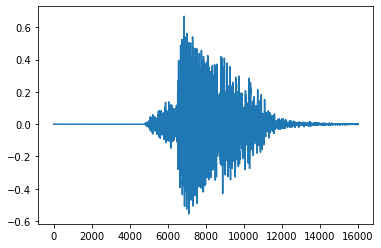

In [9]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [26]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [27]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

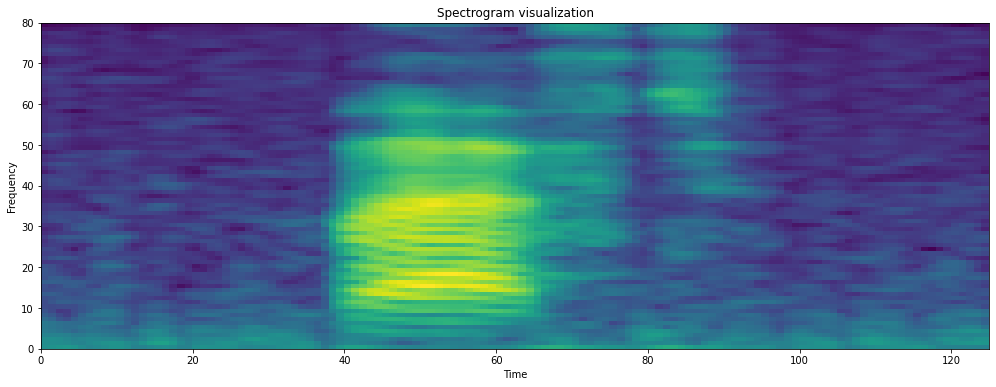

In [28]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [29]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

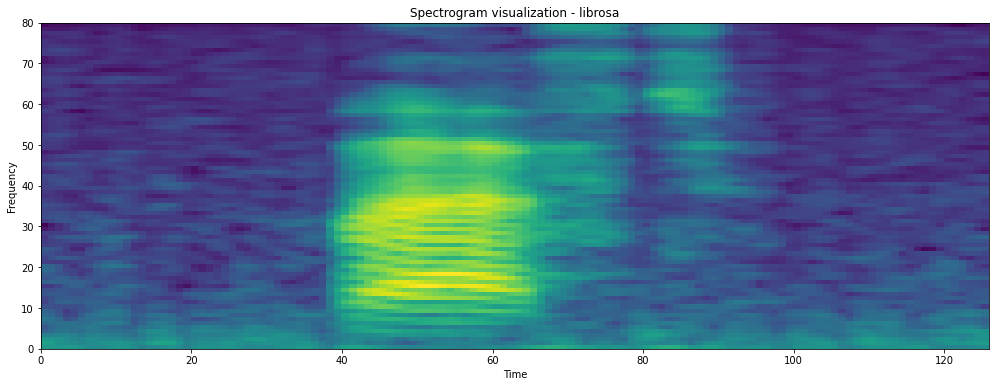

In [30]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [31]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [32]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [33]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, None, 1)  0           mel_stft[0][0]                   
____________________________________________________________________________________________

In [34]:
# model.load_weights('model-attRNN.h5')

In [35]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [36]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.h5')

Epoch 1/60
Changing learning rate to 0.001
2651/2651 - 409s - loss: 0.7617 - sparse_categorical_accuracy: 0.7849 - val_loss: 0.3624 - val_sparse_categorical_accuracy: 0.8965

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.89650, saving model to model-attRNN.h5
Epoch 2/60
Changing learning rate to 0.001
2651/2651 - 401s - loss: 0.3379 - sparse_categorical_accuracy: 0.9058 - val_loss: 0.3024 - val_sparse_categorical_accuracy: 0.9212

Epoch 00002: val_sparse_categorical_accuracy improved from 0.89650 to 0.92122, saving model to model-attRNN.h5
Epoch 3/60
Changing learning rate to 0.001
2651/2651 - 403s - loss: 0.2657 - sparse_categorical_accuracy: 0.9255 - val_loss: 0.2620 - val_sparse_categorical_accuracy: 0.9253

Epoch 00003: val_sparse_categorical_accuracy improved from 0.92122 to 0.92534, saving model to model-attRNN.h5
Epoch 4/60
Changing learning rate to 0.001
2651/2651 - 403s - loss: 0.2199 - sparse_categorical_accuracy: 0.9378 - val_loss: 0.2454 - val_sparse_

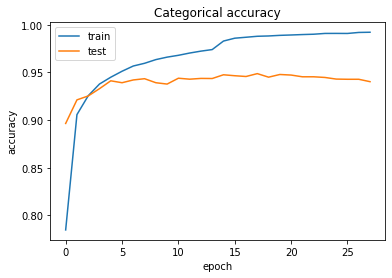

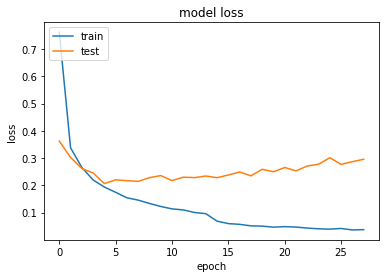

In [37]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# results.history

In [39]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('model-attRNN.h5')

In [40]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [41]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.05226822942495346, 0.9878347516059875] 
Validation: [0.24686922132968903, 0.9487540125846863] 
Test: [0.24700623750686646, 0.9415720105171204]


In [42]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [43]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [44]:
audios, classes = valGen.__getitem__(3)
classes

array([14,  5, 16, 10,  9,  2, 17, 10,  6, 17, 18,  5, 34,  6,  8, 13, 14,
        1,  9, 12, 22, 11, 35, 18,  2, 18, 29, 18,  3, 11, 12, 12])

In [45]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

6

In [46]:
outs, attW, specs = attSpeechModel.predict(audios)

In [47]:
np.argmax(outs,axis=1)

array([14,  5, 16, 10,  9,  2, 10, 10,  2, 17, 18,  5, 34,  6,  8, 13, 14,
        1,  9, 34, 22, 11, 35, 18,  2, 18, 29, 18,  3, 11, 12, 12])

In [48]:
specs.shape

(32, 80, 125, 1)

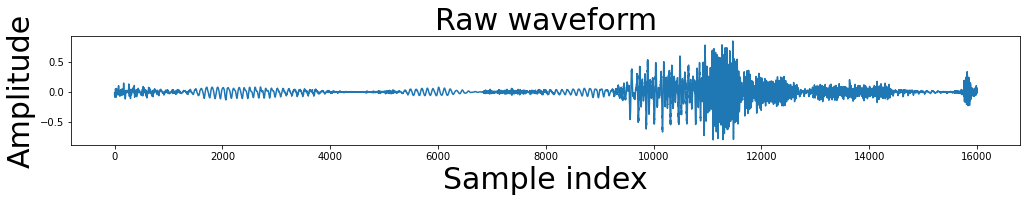

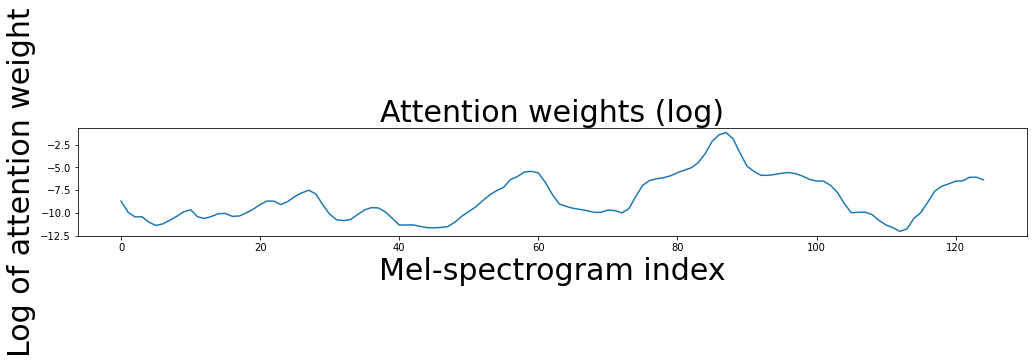

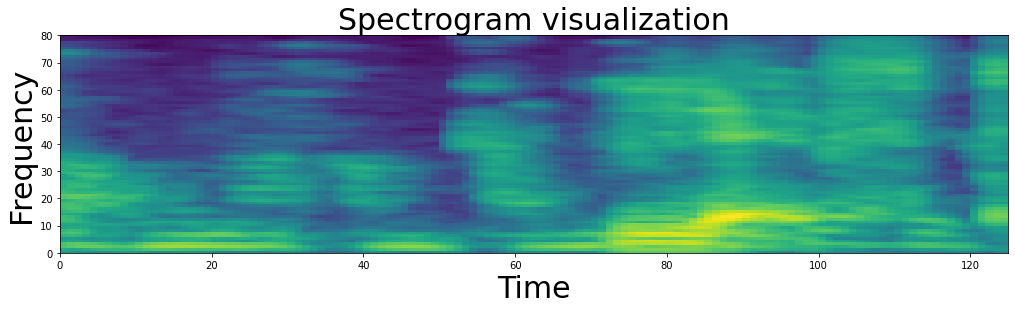

In [49]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [50]:
y_pred = model.predict(x_test, verbose=1)

344/344 [==============================] - 23s 62ms/step


In [51]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
#set(y_test)

In [52]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [53]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
#         'marvin', 'sheila', 'tree', 'wow']

In [54]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


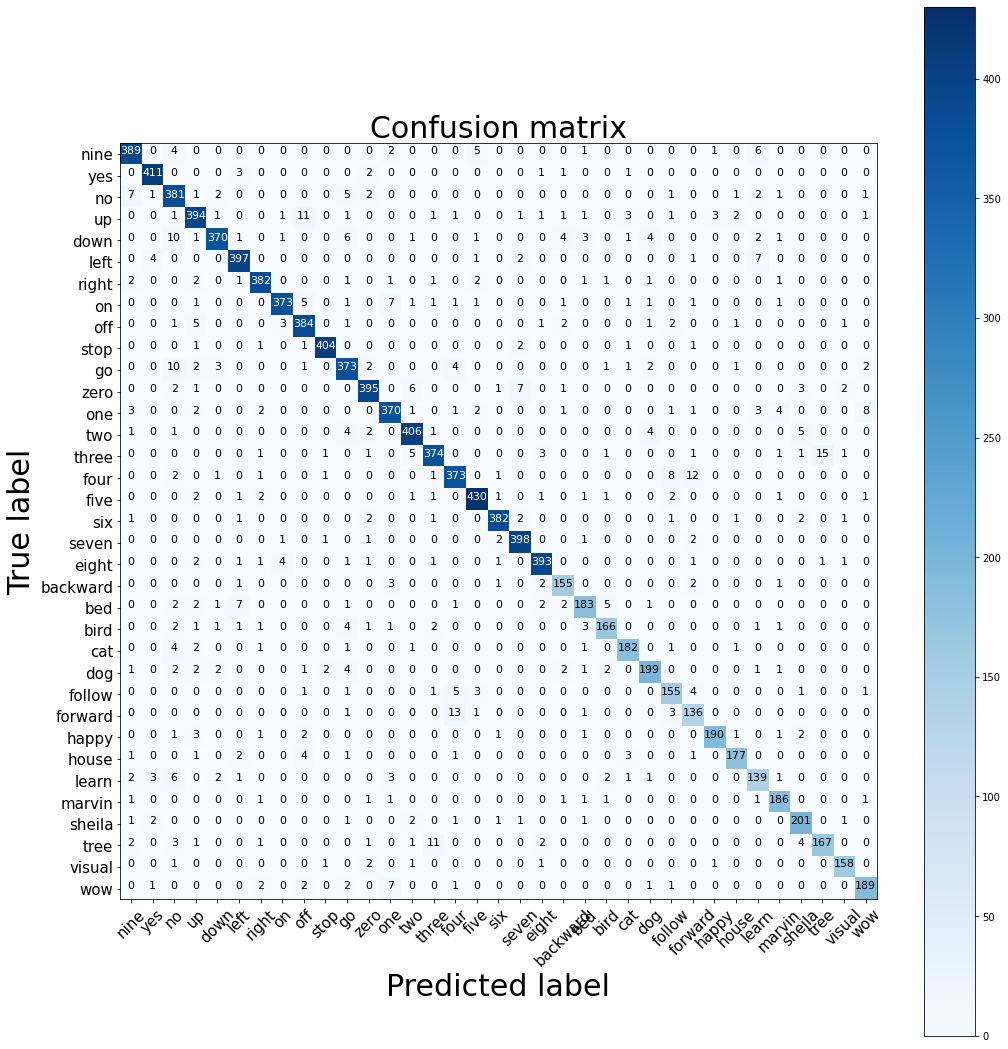

In [55]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [56]:
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.4.0', '0.2.0', '1.1.5', '0.8.0']

# Save model to .pb

In [57]:
#model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
#model.load_weights('model-attRNN.h5')

model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [58]:
tf.saved_model.save(model, "attRNNModel/1/")

INFO:tensorflow:Assets written to: attRNNModel/1/assets


INFO:tensorflow:Assets written to: attRNNModel/1/assets


In [59]:
import os
os.listdir('attRNNModel/1/')

['assets', 'saved_model.pb', 'variables']

In [60]:
# if using tensorflow 1.x

In [61]:
# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.
    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph



In [62]:
wkdir = ''
pb_filename = 'attRNN.pb'

# save keras model as tf pb files ===============
sess = tf.compat.v1.keras.backend.get_session()

#frozen_graph = freeze_session(sess,
#                              output_names=[out.op.name for out in model.outputs])
#tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)